### Make the necessary imports (libraries)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras as k

from keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam


import os
import time
import tarfile
import pickle
import gzip
import requests



In [2]:
def download_cifar10():
  working_path = os.getcwd()
  cifar_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
  file_name_gz = "cifar-10-python.tar.gz"
  file_name_tar = "cifar-10-python.tar"

  file_path_gz = os.path.join(working_path, file_name_gz)
  file_path_tar = os.path.join(working_path, file_name_tar)

  if os.path.exists(file_path_tar):
      print("The file cifar-10-python.tar already exists")
  else:
      print("Downloading CIFAR-10 data...")
      response = requests.get(cifar_url, stream=True)
      response.raise_for_status()
      with open(file_path_gz, 'wb') as f:
          for chunk in response.iter_content(chunk_size=8192):
              if chunk:
                  f.write(chunk)

      with gzip.open(file_path_gz, 'rb') as f_in:
          with open(file_path_tar, 'wb') as f_out:
              for chunk in f_in:
                  f_out.write(chunk)
      print
  return file_path_tar

download_cifar10()

The file cifar-10-python.tar already exists


'/content/cifar-10-python.tar'

### Load the data from a tar file (using pickle)

In [3]:
def load_pickle_from_tar(tar_path, pickle_path):
    with tarfile.open(tar_path, 'r') as tar:
        member = tar.getmember(pickle_path)
        f = tar.extractfile(member)
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

# Set your tar_path to the file in the same working folder
tar_path = "cifar-10-python.tar"  # File in the same working directory

# Load training data
train_data = []
train_labels = []

print("Loading training data...")
# The path structure below is based on the standard CIFAR-10 distribution
for i in range(1, 6):
    batch_path = f'cifar-10-batches-py/data_batch_{i}'
    print(f"Loading batch {i}...")
    batch_dict = load_pickle_from_tar(tar_path, batch_path)
    train_data.append(batch_dict[b'data'])
    train_labels.extend(batch_dict[b'labels'])

train_data = np.vstack(train_data)

Loading training data...
Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...


### Load the training/test data set and label names

In [4]:
print("Loading test data...")
test_batch_path = 'cifar-10-batches-py/test_batch'
test_dict = load_pickle_from_tar(tar_path, test_batch_path)
test_data = test_dict[b'data']
test_labels = test_dict[b'labels']

# Load label names
print("Loading label names...")
meta_path = 'cifar-10-batches-py/batches.meta'
meta_dict = load_pickle_from_tar(tar_path, meta_path)
label_names = [label.decode('utf-8') for label in meta_dict[b'label_names']]

# Print basic info about the data
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Label names: {label_names}")


Loading test data...
Loading label names...
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Reshape the data to match the expected input format for CNN

In [5]:

# Each image is 32x32 pixels with 3 color channels (RGB)
X_train = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
X_test = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Print updated shapes
print("Training data shape after reshaping:", X_train.shape)
print("Test data shape after reshaping:", X_test.shape)


Training data shape after reshaping: (50000, 32, 32, 3)
Test data shape after reshaping: (10000, 32, 32, 3)


### Conduct preprocessing of the data:
- Normalization (from 255 to 0/1)
- Convert class vectors to binary class matices (via one-hot encoding)
- Create validation data set (of 10% of training data)

In [6]:
# Preprocess the data
def preprocess_data(X_train, y_train, X_test, y_test):
    # Normalize pixel values to be between 0 and 1
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Convert class vectors to binary class matrices
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Create a validation set (10% of training data)
    val_size = int(0.1 * X_train.shape[0])
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train = X_train[:-val_size]
    y_train = y_train[:-val_size]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Apply preprocessing
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

# Print updated shapes
print("Training data shape after preprocessing:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape after preprocessing: (45000, 32, 32, 3)
Validation data shape: (5000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

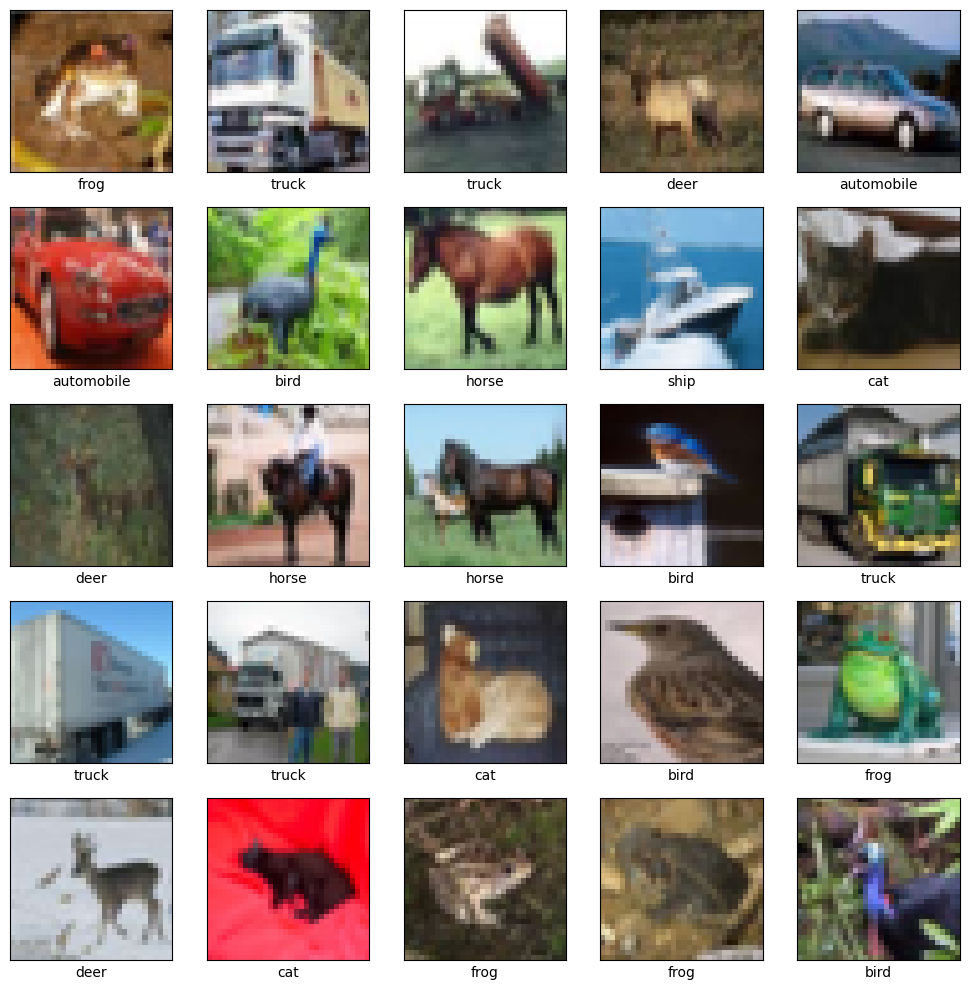

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(label_names[np.argmax(y_train[i])])
plt.tight_layout()
plt.show()


### Let's define our CNN model (architect)
-
-


In [9]:
# Helper function before your create_cnn_model function
def residual_block(x, filters, use_projection=False):
    """Create a residual block with skip connection"""
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution (no activation yet)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if use_projection or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection and apply final activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


# Modified create_cnn_model function with residual blocks
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    # Use Functional API instead of Sequential for residual connections
    inputs = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # First residual block (32 filters)
    x = residual_block(x, filters=32, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second residual block (64 filters)
    x = residual_block(x, filters=64, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Third residual block (128 filters)
    x = residual_block(x, filters=128, use_projection=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Classifier (same as your simplified version)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0005),  # Half the default rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 319,466 (1.22 MB)

 Trainable params: 318,058 (1.21 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [10]:
def apply_data_augmentation():
  """Apply data augmentation using tf.image (Keras 3.x compatible)"""

  @tf.function
  def augment_image(image, label):
    # Only horizontal flip (most conservative augmentation)
    image = tf.image.random_flip_left_right(image)

    # Very mild brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.05)

    # Ensure values stay in [0,1] range
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

  # Create tf.data dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

  return train_dataset


def apply_mild_data_augmentation():
    """Apply very conservative data augmentation"""
    datagen = ImageDataGenerator(
        horizontal_flip=True,          # Only horizontal flip
        width_shift_range=0.05,        # Very small shifts (5%)
        height_shift_range=0.05,       # Very small shifts (5%)
        rotation_range=5               # Very small rotation (5 degrees)
    )

    # Fit the augmentation parameters to training data
    datagen.fit(X_train)
    return datagen

# Create the mild augmentation generator



In [11]:
# Define callbacks for early stopping and model checkpoint
from keras.callbacks import EarlyStopping #, ModelCheckpoint
k.backend.clear_session()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #,
    # ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy',
    #                save_best_only=True, mode='max')
]


train_dataset = apply_data_augmentation()
#datagen = apply_mild_data_augmentation()

# Train the model
start_time = time.time()
history = model.fit(
    train_dataset,
    #datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.2653 - loss: 2.0828 - val_accuracy: 0.4916 - val_loss: 1.3703
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4680 - loss: 1.4664 - val_accuracy: 0.6032 - val_loss: 1.1115
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5441 - loss: 1.2772 - val_accuracy: 0.5432 - val_loss: 1.2699
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5882 - loss: 1.1734 - val_accuracy: 0.6022 - val_loss: 1.1138
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6219 - loss: 1.0817 - val_accuracy: 0.5682 - val_loss: 1.1945
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6410 - loss: 1.0335 - val_accuracy: 0.6052 - val_loss: 1.1694
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6657 - loss: 0.9718 - val_accuracy: 0.6750 - val_loss: 0.9240
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6785 - loss: 0.9221 - val_accuracy: 

### It stopped at 24 epochs, it must have not improve for 10 consecutive epochs

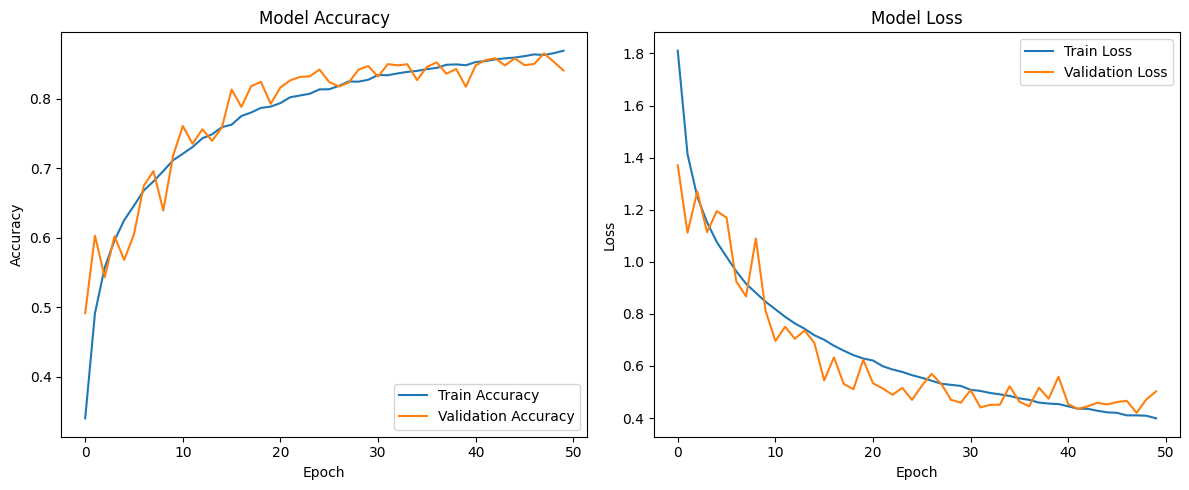

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8545 - loss: 0.4607
Test accuracy: 0.8534
Test loss: 0.4578


In [12]:
# Plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

### The CNN model shows:

- Good Learning: Training accuracy reached ~94%, validation ~84-85%
- Moderate Overfitting: ~9-10% gap between training and validation metrics
- Early Plateau: Most learning occurred in first 10 epochs
- Stable Validation: Validation metrics stabilized without deteriorating

The curves show a well-functioning model that's starting to memorize training data rather than learning generalizable features.

In [13]:
# Predict classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.96      0.89      0.93      1000
        bird       0.92      0.70      0.80      1000
         cat       0.72      0.72      0.72      1000
        deer       0.85      0.84      0.85      1000
         dog       0.77      0.81      0.79      1000
        frog       0.81      0.94      0.87      1000
       horse       0.90      0.89      0.90      1000
        ship       0.89      0.94      0.92      1000
       truck       0.87      0.94      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



### Class Performance

- Overall Accuracy: 84.2% on test set
- Best Classes: Vehicles (ships 92.1%, automobiles 91.8%)
- Struggling Classes: Cats (62.1% correct), birds (75.9%)
- Man-made vs Natural: Vehicles (90% F1) outperform animals (80% F1)

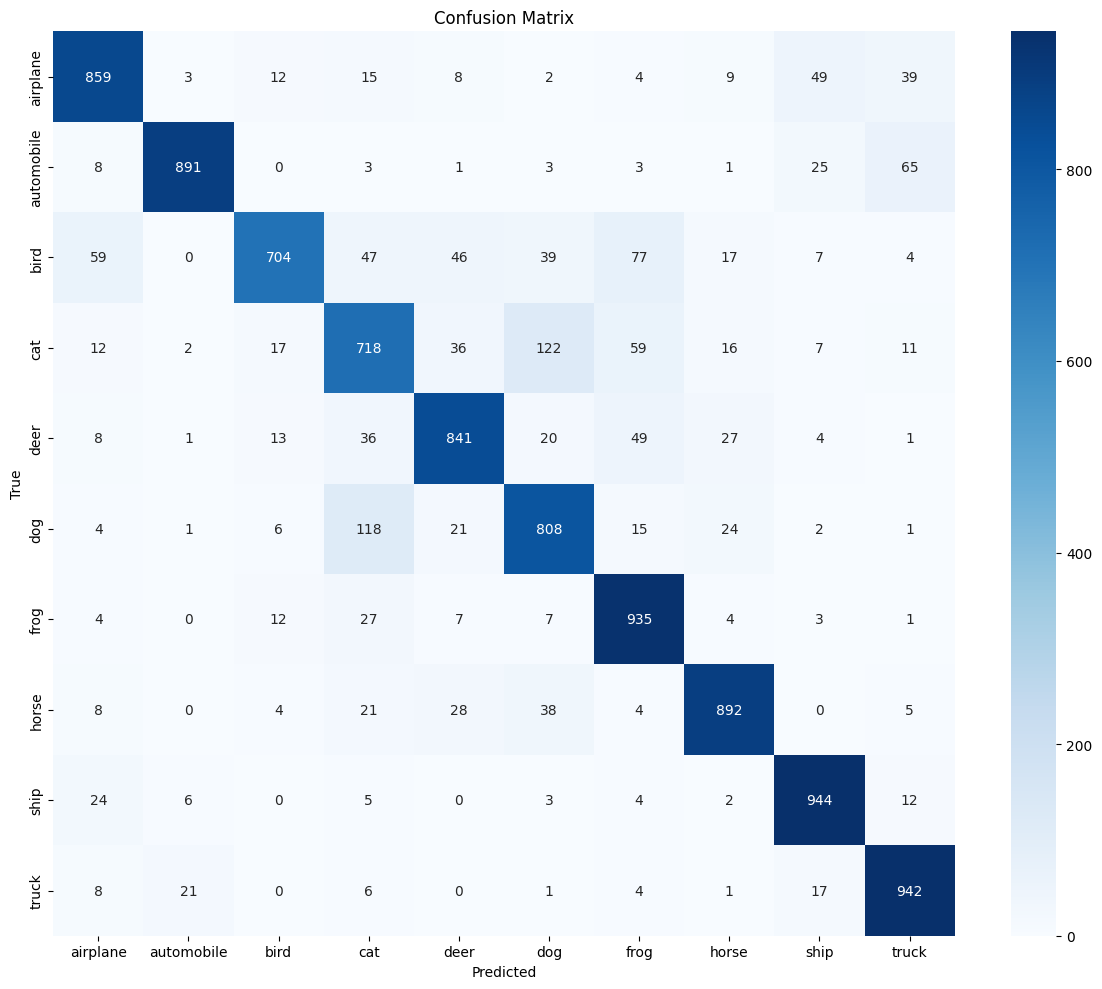

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Confusion Matrix patterns:
- Cat-Dog Confusion: 159 cats misclassified as dogs (biggest issue)
- Vehicle Confusion: Some automobile-truck confusion (expected)
- Animal Misclassifications: Widespread confusion among mammals

Pattern: Classes with consistent appearances perform best

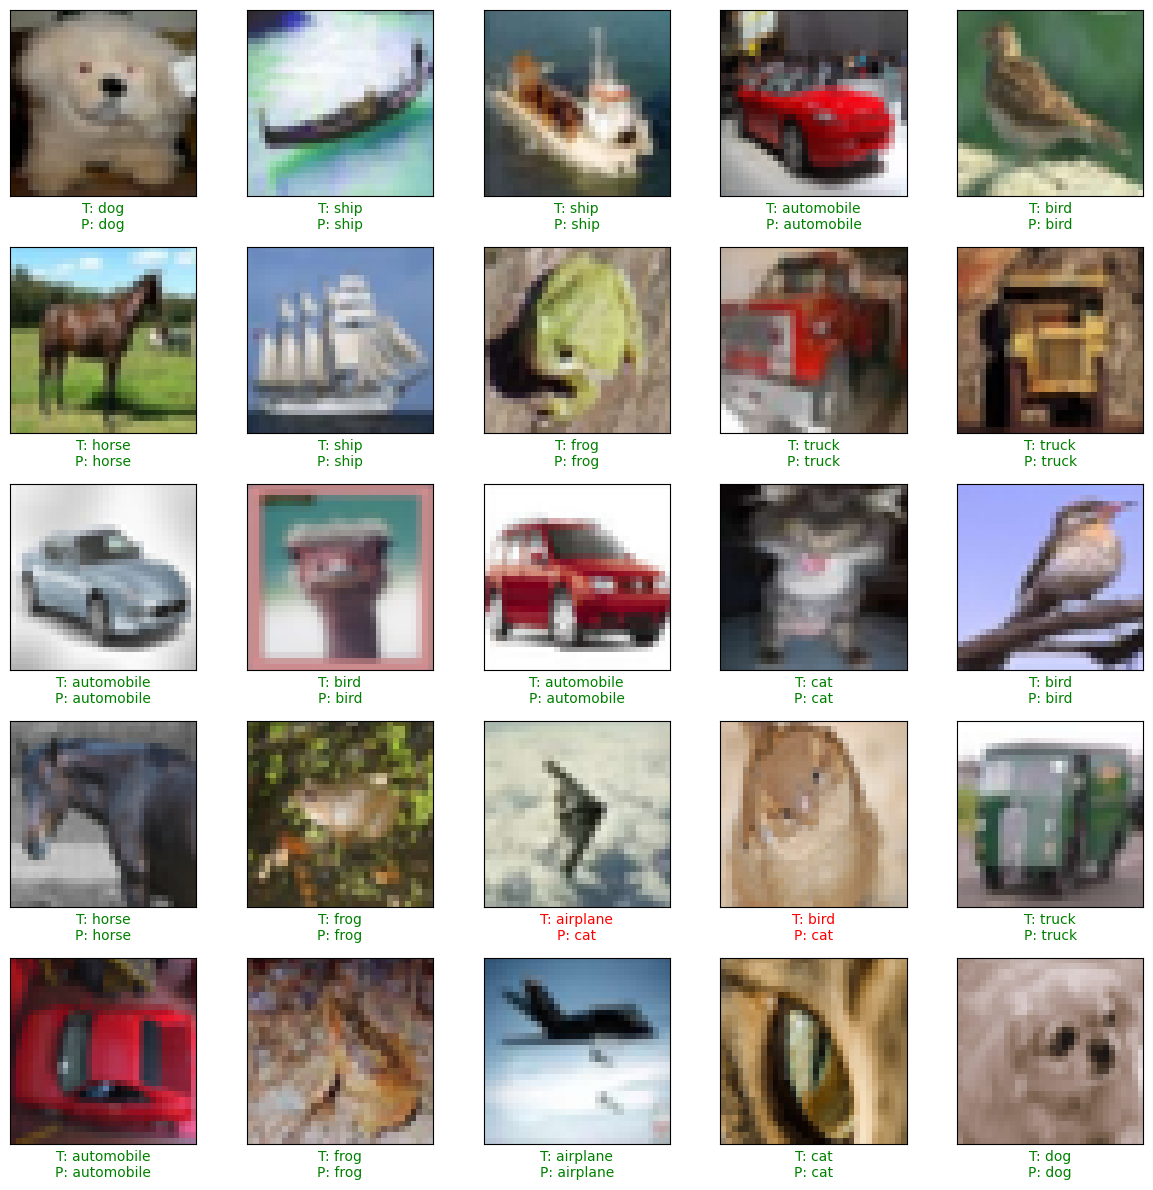

Model saved as 'cifar10_cnn_model.keras'


In [15]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, class_names, num_images=25):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])

        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.xlabel(f"T: {true_label}\nP: {pred_label}", color=color)
    plt.tight_layout()
    plt.show()

# Get a subset of test data
sample_indices = np.random.choice(len(X_test), 25, replace=False)
visualize_predictions(
    X_test[sample_indices],
    y_true_classes[sample_indices],
    y_pred_classes[sample_indices],
    label_names
)

# Save the trained model
model.save('cifar10_cnn_model.keras')
print("Model saved as 'cifar10_cnn_model.keras'")